# Introduction to Machine Learning
## Computer self-study assignment week 6 
## Neural Networks & MNIST database

Content:
1. Neural Networks
2. MNIST database of handwritten digits

## 1. Neural Networks
We will study some properties of neural networks for regression. We will use scikit-learn's implementation. It is advised to have a look at the <a ref="https://scikit-
learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html">scikit MLPRegressor</a>.

Let us start with some import.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

### Neural networks are universal approximators

The claim is that neural networks with sufficiently many hidden units can approximate any function arbitrary well.

In the following code I try to approximate the sin-function in 1-D with a neural network. Note that htis is not about training and generalization: I just want tot fit the `sin()` function as good as possible to assess the universal approximation property of a neural network.

Some remarks about parameter choices: 
`solver='lbfgs'`, a Newton-like method. In particular suited for 'small datasets'. With large data sets, the other gradient-descent solvers are better suited.

`tol=1emax-10`, `max_iter=1000` These numbers are chosen to push the fit as far as possible. Play with these values (e.g. lower number of iterations) and see what happens (we will come back to the number of iterations later).

`activation='tanh'`. Typically `tanh` or `relu` are chosen (`relu` is nowadays more popular). In this case `identity` is not a good choice. Why?

`random_state = 1` is for reproducibility. Different `random_states` may lead to different results, e.g. due to different weight initializations.

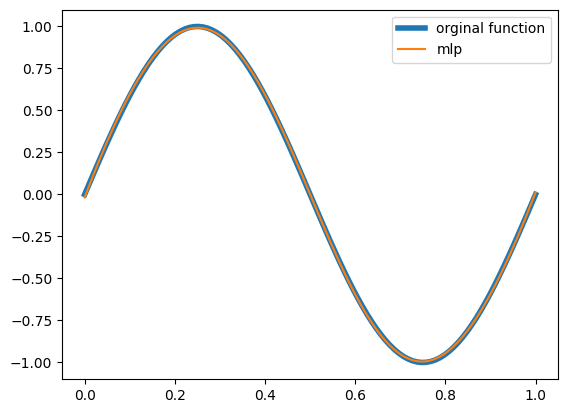

In [18]:
X = np.linspace(0,1,100)
y = np.sin(2*np.pi*X)      # our target function
#y = (np.sin(1/(X+0.1)))

n_hiddens=10    # number of hidden units (one layer of hidden units)
h_fun = 'tanh'   # activation function (typical: 'relu' or 'tanh' not so typical: 'identity')
ranstate=5      # for reproducibility of the MLP

mlp = MLPRegressor(hidden_layer_sizes=(n_hiddens,), 
                   solver = 'lbfgs',activation = h_fun,
                   tol=1e-10, max_iter=1000, random_state=ranstate)

mlp.fit(X.reshape(-1,1), y)
y_mlp = mlp.predict(X.reshape(-1,1))

plt.plot(X,y,label = 'orginal function',linewidth=4)
plt.plot(X,y_mlp ,label = 'mlp')
plt.legend()
plt.show()

Try different values of `n_hidden`, (choose 1, 2, 3, 10, 100, etc.). If you choose 1, you will recognize the activation function.

Try different acitvation functions.

Try different target functions (instead of `sin(2*np.pi*X)`)

What I found remarkable is how well some functions are approximated by neural networks with only a few nodes.



### Regularization and Early Stopping in Neural Networks
See Bishop 5.5 page 256-257, Figure 5.9, and equation 5.112

Simulate (as with the polynomial curve fitting) a training set of 10 data points from the sin-function + noise. Then train a neural network with 10 hidden units. Set `alpha=0`, and other parameters as below, and observe that the neural network will overfit.

In [ ]:
def myfun_gt(x):
    ygt = np.sin(2*np.pi*x)
    return ygt

def myfun_Noise(x):
    ranseed =  2            #for reproducibility (but you can use a different seed if desired)
    np.random.seed(ranseed) #for reproducibility (but you can use a different seed if desired)
    mysigma = 0.3
    y = myfun_gt(x) + mysigma*np.random.randn(x.size)
    return y


X_train = np.linspace(0,1,10)
y_train = myfun_Noise(X_train.reshape(-1,))


X_test = np.linspace(0,1,100)
y_gt = myfun_gt(X_test)


n_hiddens=100
alpha=0.0

max_iter=1000
ranstate=3

mlp = MLPRegressor(hidden_layer_sizes=(n_hiddens,), solver = 'lbfgs',activation = 'tanh', 
                   tol=1e-10, max_iter = max_iter, random_state=ranstate, alpha=alpha)
mlp.fit(X_train.reshape(-1,1), y_train)
y_mlp = mlp.predict(X_test.reshape(-1,1))

plt.plot(X_train, y_train,'o',label='training data')
plt.plot(X_test, y_gt, label='ground truth')

plt.plot(X_test, y_mlp, label='mlp')
plt.legend()
plt.show()
print('test error = {}'.format(mean_squared_error(y_mlp,y_gt)))

- Try different values of hidden units. In Fig 5.9, Bishop finds good results with `n_hiddens=3`. What are your experiences? Is it consistent (try for each number of hidden units different values of ranstate in the neural networks and different ranseeds in the data generation)?
- set `n_hiddens=100`. Now **vary** the regularization term **alpha** (which always plays the role $\lambda$ in Bishop's equations 5.112). Try different values, e.g. **alpha=0.001, 0.01, 0.1, 1** and compare results.
Same question: What are your experiences? Is it consistent (try for each number of hidden units different values of ranstate in the neural networks an different ranseed in the data generation)?
- set `n_hiddens=100` and `alpha=0`. Now vary the maximum number of iterations `max_iter`. Try different values, e.g. **max_iter=1,2,3,4,5,10,15,20,30,40,50,100** and compare results.
(When I do this, I get a warning like:

`ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.`

(But of course it is on purpose that the lbfgs algorithm didn't converge)

Same question: What are your experiences? Is it consistent (try for each number of hidden units different values of ranstate in the neural networks and different ranseed in the data generation)?
See discussion in Bishop 5.5.2 Early stopping.

NB: scikit-learn as a **build in function for early-stopping** based on a validation set:

`early_stopping` : **bool, default=False**
Whether to use an early stopping to terminate training when validation score is not improving. If set to `True`, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least `tol` for `n_iter_no_change` consecutive epochs. Only effective when `solver='sgd'` or `adam`

`validation_fraction`:**float, default=0.1**
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if `early_stopping` is `True`.

Note that it is not working for the lbfgs solver.

## Scaling of input variables
Scaling of input variables is often important in neural networks.

Usually it is advised to scale your inputs so that it has mean zero and standard deviation 1.

Let us try to learn a stretched $\sin(x)$ using a neural network with the `adam` solver. (Adam is a stochastic gradient descent scheme with some smart tricks).
In the code below, a and b are scale parameters. First try without scaling (`a=0`, `b=1`) as in the code below, then try with:
- `a=500`, `b=1` (bring mean to zero)
- `a=0`, `b=289` (std is 1)
- `a=500`, `b=289` (mean zero, std=1)

Observe the results, and keep in mind for your future applications that scaling can have an influence on your neural network performance.

In [ ]:
a = 0
b = 1

#a = 500
#b = 1

#a = 0
#b = 289

#a = 500
#b = 289

np.random.seed(1) 
X_orig = np.linspace(0,1000,1000) 
y_orig = np.sin(2*np.pi*X_orig/1000)  


X = (X_orig - a)/b     # scaled input data
y = y_orig 

n_hiddens=100
alpha=0.0

max_iter=10000
ranstate=3

mlp = MLPRegressor(hidden_layer_sizes=(500,), solver = 'adam', activation = 'relu', 
                   learning_rate_init=0.1, tol=1e-10, max_iter=max_iter,
                   random_state=ranstate, alpha=alpha)
mlp.fit(X.reshape(-1,1), y)
y_mlp = mlp.predict(X.reshape(-1,1))

plt.plot(X_orig,y_orig,'o', label='data stretched sin(x)')
plt.plot(X_orig,y_mlp, label='neural network fit')
plt.legend()
plt.show()

## Data augmentation

Let us try to extend the training set `X_train, y_train` that we have generated earlier with noisy copies (1,10,100) of the training samples. 
Do some experiment with the amount of data copies and the amount of noise e.g. std=0.01, 0.05, 0.1, 0.2 etc. (and might be different in x and y direction).

Note that this is a toy problem, with toy data. In practice, more advanced data augmentation techniques (e.g. to express invariances) may be needed. See Bishop 5.5.3, first bullet point and its discussion.

In [ ]:
ncopies = 1
epsilonx = 0.1
epsilony = 0.1
X_trainA = X_train  
y_trainA = y_train

for i in np.arange(ncopies):
    X_trainA = np.r_[X_trainA,X_train+epsilonx*np.random.randn(10)]
    y_trainA = np.r_[y_trainA,y_train+epsilony*np.random.randn(10)]


Now train with the augmented training set (and test as earlier)

In [ ]:


n_hiddens=100
alpha=0.0

max_iter=1000
ranstate=3

mlp = MLPRegressor(hidden_layer_sizes=(n_hiddens,), solver = 'lbfgs',activation = 'tanh', 
                   tol=1e-10, max_iter = max_iter, random_state=ranstate, alpha=alpha)
mlp.fit(X_trainA.reshape(-1,1), y_trainA)
y_mlp = mlp.predict(X_test.reshape(-1,1))

plt.plot(X_trainA, y_trainA,'o',label='training data')
plt.plot(X_test, y_gt, label='ground truth')

plt.plot(X_test, y_mlp, label='mlp')
plt.legend()

print()
plt.show()
print('test error = {}'.format(mean_squared_error(y_mlp,y_gt)))

## 2. MNIST database of handwritten digits

MNIST is a famous machine learning database. It consists of 70 000 records. Each record has 784 (=28x28) features. More information can be found on the internet, on in Bishop’s book, Appendix D - but also in the description in sklearn's version of MNIST (See below).

Load the MNIST database into the BUNCH object mnist (note: it is quite some data, so this may take a short while):

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

The result is a ‘bunch’ object (like the Iris data set from week 1). Some info about the database can be found via the following command:

In [ ]:
print(mnist['DESCR'])

Let us define the usual data matrix X and target vector y as numpy arrays, and show their shape.

In [ ]:
#Input data and targets as numpy arrays (because we are used to them)
X = np.array(mnist['data'])    
y = np.array(mnist['target'])
print(X.shape)
print(y.shape)

First let us have a look a the targets. 

In [ ]:
print(y)

Then, to get an idea of the structure of the input data, let us print the first row of X (i.e. the data vector corresponding to the first digit in the data base y[0]). Maybe you already see a pattern in this data.

In [ ]:
print(X[0])

However, we get a much nicer display if we reshape the feature vector as an 28x28 array and display it with plt.imshow(), as below:

In [ ]:
plt.imshow(X[0].reshape(28,28), cmap='binary')   # binary cmap is a colormap of grey-scales
#plt.axis("off") # If you only want the image, not the axes
plt.xticks([])   # If you only want the image, and the axes, but no ticks
plt.yticks([])
print('The image below should look like a: ',y[0])     # what is the target (which digit should the image resemble?)
plt.show()

Let us print some more images, e.g. the first 10 images from all the 10 digits [0,...,9]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

k=0
for i in np.arange(10):
    Xt = X[:1000][np.where(y[:1000]==str(i))] # I only look in the first 1000
    for j in np.arange(10):
        k+=1
        ax=plt.subplot(10, 10, k)          
        plt.imshow(Xt[j].reshape(28,28), cmap='Greys')
        #plt.axis("off") # If you only want the image, not the axes
        plt.xticks([])   # If you only want the image, and the axes, but no ticks
        plt.yticks([])

plt.show()

